# Practica 1

 Autor: Lucas Gallego Bravo
NIA: 100429005

Antes de comenzar con la codificación de la práctica, he decidido juntar en un único fichero .csv los datos de los 5 años proporcionados en la página web, creando asi el fichero gt_full.csv. El cual utilizare para la realización de la práctica propuesta.

# Preprocesamiento de los datos

Antes de codificar el ADALINE y entrenar las redes de neuronas debemos preparar los datos que tenemos para su correcto funcionamiento, esta preparación incluye la normalización de los datos, aleatorización y la separación en tres conjuntos (entrenamiento, validación y test).

Primero debemos realizar los install e imports que necesitaremos para el correcto funcionamiento de la práctica:

In [220]:
# Primero debemos realizar los install e imports necesarios de las librerias que vayamos a utilizar:

!pip3 install numpy
!pip3 install pandas

import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import statistics

Una vez hecho esto, debemos abrir los datos que tenemos y normalizarlos

## Apertura y normalización de los datos

In [221]:
# Primero realizamos la apertura de los datos en nuestro código

datos = pd.read_csv("./gt_full.csv")

feature_names_disp = datos.columns.values.tolist()

datos = datos[feature_names_disp[0:11]]

dataFrame = pd.DataFrame(datos)

maximos = dataFrame.max()

minimos = dataFrame.min()

# En las variables maximos y minimos tenemos los maximos y minimos de cada variable del dataFrame, si realizamos minimos[0], obtenemos el valor minimo de la variable AT que es -6.234800

# Una vez tenemos los datos necesarios, podemos empezar a normalizar

i = 0
j = 0


while j < 11:

  min_column = minimos[j]
  max_column = maximos[j]


  if j ==7:
    max_TEY = max_column
    min_TEY = min_column

  var1 = dataFrame.iloc[i,j] - min_column
  var2 = max_column - min_column

  norm_val = var1 / var2

  dataFrame.iloc[i,j] = norm_val

  i += 1

  if i == 36733 :

    i = 0
    j += 1

## Aleatorización de los datos

Una vez tenemos listos los datos con los que vamos a trabajar, debemos desordenar los datos que tenemos para que se pueda realizar un entrenamiento adecuado de las redes

In [222]:
dataFrameRandom = dataFrame.sample(frac=1, random_state=72).reset_index(drop=True)

## Separación de los tres conjuntos de datos


Una vez se han realizado los pasos anteriores, debemos dividir los datos en 3 subcojuntos, entrenamiento (70%), validación (15%) y test (15%).

In [223]:
entrenamiento = dataFrameRandom[0:25713]

validacion = dataFrameRandom[25713:31223]

test = dataFrameRandom[31223:]

Una vez divididos, crearemos un csv para cada subconjunto:

In [224]:
entrenamiento.to_csv('entrenamiento.csv',index=False)

validacion.to_csv('validacion.csv',index=False)

test.to_csv('test.csv',index=False)

#  PARTE-1: Adaline

Primero debemos crear el código de nuestro Adaline:

In [225]:
class AdalineLGB:
    def __init__(self, learning_rate=0.01, n_iterations=100, random_seed=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.pesos = None
        self.umbral = None
        self.best_pesos = None
        self.best_umbral = None
        self.best_error = 1
        self.random = random_seed
        self.train_error_list=[]
        self.val_error_list=[]

        if random_seed is not None:
            np.random.seed(random_seed)

    def initialize_weights(self, n_features):
        # Inicialización de pesos y umbral de manera aleatoria
        self.rgen = np.random.RandomState(self.random )
        self.pesos = self.rgen.normal(loc=0.0, scale=0.01, size = n_features)
        self.umbral = np.random.rand()

    def fit(self, X_train, y_train, X_validation, y_validation):
        n_features = X_train.shape[1]
        self.initialize_weights(n_features)

        for epoch in range(self.n_iterations):
            for i in range(X_train.shape[0]):
                # Paso 2: Presentar un patrón de entrada
                sample = X_train[i]
                desired_output = y_train[i]

                # Paso 3: Calcular la salida de la red y yp
                output = self.net_input(sample)
                error = desired_output - output

                # Paso 4: Modificar los pesos y el umbral utilizando la regla delta
                self.pesos += self.learning_rate * error * sample
                self.umbral += self.learning_rate * error

            # Paso 6: Evaluar el error de la red sobre el conjunto de entrenamiento
            training_error = self.calculate_error(X_train, y_train)
            self.train_error_list.append(training_error)

            # Paso 7: Evaluar el error de la red sobre el conjunto de validación
            validation_error = self.calculate_error(X_validation, y_validation)
            self.val_error_list.append(validation_error)

            # Paso 8: Almacenar el mejor modelo
            if validation_error < self.best_error:
                self.best_error = validation_error
                self.best_pesos = self.pesos.copy()
                self.best_umbral = self.umbral

            # Enseñamos en pantalla los errores con 6 decimales, si se quieren ver mas, cambiar el .6f por un numero mas alto
            print(f'Iteracion {epoch + 1} - Error de entrenamiento: {training_error:.6f} - Error de validación: {validation_error:.6f}')

        # Usar el mejor modelo para pruebas
        self.pesos = self.best_pesos
        self.umbral = self.best_umbral

    def net_input(self, X):
        return np.dot(X, self.pesos) + self.umbral

    def predict(self, X):
        return self.net_input(X)

    def calculate_error(self, X, y):
        predictions = self.predict(X)
        errors = y - predictions
        return (errors ** 2).mean()

Una vez creado nuestro Adaline, debemos entrenarlo con los datos de entrenamiento.csv
Para ello primero leeremos los datos del csv, para posteriormente dividir el subconjunto en X e Y, siendo en este caso la Y los valores de la variable TEY, que es la cual se desea predecir. Por el contrario X seran el resto de datos sin TEY.

In [226]:
entrenamiento=pd.read_csv("./entrenamiento.csv")
df = entrenamiento.drop(columns=["TEY"])
target = entrenamiento["TEY"]
ds = df.T

#Entrenamiento
X_train = entrenamiento.drop(columns=["TEY"])
y_train = entrenamiento["TEY"]
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()


test=pd.read_csv("./test.csv")

#Entrenamiento
X_test = test.drop(columns=["TEY"])
y_test = test["TEY"]
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()


validacion = pd.read_csv("./validacion.csv")

#Validacion
X_validacion = validacion.drop(columns=["TEY"])
y_validacion = validacion["TEY"]
X_validacion = X_validacion.to_numpy()
y_validacion = y_validacion.to_numpy()

## Cargar los datos del mejor modelo

Esta parte solo se debe ejecutar si ya se dispone de un fichero que contenga los mejores pesos y umbrales para el Adaline.

In [ ]:
#Cargamos el fichero que contiene los datos del mejor modelo
mejor_modelo=pd.read_csv("./mejor_modelo_Adaline.csv")
mejor_modelo= mejor_modelo.loc[0]

Adaline = AdalineLGB()
# Metemos dichos datos a nuestro Adaline
pesos = mejor_modelo["Pesos"]   # Aqui es una string
Adaline.umbral = mejor_modelo["Umbral"]

# Con este bucle se pasan los pesos de string a float
elem=0
var2=[]
i = pesos[elem]
while i != "]":
  i = pesos[elem]
  if i!="[" and i!=" " and i!="\n":
    var = ""
    while i!=" " and i!="\n" and i!="]":
      i = pesos[elem]
      if i =="\n" or i=="]" or i==" ":
        break
      var = var + i
      elem += 1

    var3 = float(var)
    var2.append(var3)
  elem += 1

# Finalmente, añadimos los pesos al Adaline
Adaline.pesos = var2

## Entrenar el Adaline

Esta parte del codigo se ejecuta si no se dispone del fichero que tiene los mejores pesos y umbral, de esta forma entrenamos el Adaline y podemos realizar la prediccion sobre el conjunto de test.

In [227]:
# Inicializamos el Adaline con los hiperparametros que queremos
Adaline = AdalineLGB(learning_rate=0.003 ,n_iterations=30, random_seed = 2)

# Realizamos el entrenamiento de nuestro Adaline con los datos de entrenamiento, y añadimos los de validación para ver su error a lo largo del entrenamiento
inicio = time.time()
Adaline.fit(X_train, y_train, X_validacion, y_validacion)
final = time.time()
tiempo = final - inicio
print("Se han tardado: ",tiempo, " segundos")

Iteracion 1 - Error de entrenamiento: 0.000600 - Error de validación: 0.000589
Iteracion 2 - Error de entrenamiento: 0.000333 - Error de validación: 0.000330
Iteracion 3 - Error de entrenamiento: 0.000265 - Error de validación: 0.000265
Iteracion 4 - Error de entrenamiento: 0.000238 - Error de validación: 0.000240
Iteracion 5 - Error de entrenamiento: 0.000223 - Error de validación: 0.000225
Iteracion 6 - Error de entrenamiento: 0.000213 - Error de validación: 0.000215
Iteracion 7 - Error de entrenamiento: 0.000205 - Error de validación: 0.000208
Iteracion 8 - Error de entrenamiento: 0.000199 - Error de validación: 0.000202
Iteracion 9 - Error de entrenamiento: 0.000194 - Error de validación: 0.000197
Iteracion 10 - Error de entrenamiento: 0.000190 - Error de validación: 0.000193
Iteracion 11 - Error de entrenamiento: 0.000187 - Error de validación: 0.000189
Iteracion 12 - Error de entrenamiento: 0.000184 - Error de validación: 0.000186
Iteracion 13 - Error de entrenamiento: 0.000182 -

## Guardar en fichero el mejor modelo y la evolucion del error

In [228]:
# Se guarda en fichero el mejor umbral y los mejores pesos de nuestro Adaline.

mejor_modelo = pd.DataFrame(columns=["Pesos","Umbral"])
mejor_modelo.loc[0] = [Adaline.best_pesos,Adaline.best_umbral]
mejor_modelo.to_csv('mejor_modelo_Adaline.csv', index=False)

# Una vez se ha entrenado el modelo, tambien debemos guardar la evolución del error a lo largo de las iteraciones:

evolucion_error= pd.DataFrame(columns=["Train_Error","Val_Error"])
for elem in range(0,Adaline.n_iterations):
  evolucion_error.loc[elem] = [Adaline.train_error_list[elem],Adaline.val_error_list[elem]]

evolucion_error.to_csv('evolucion_error_Adaline.csv', index=False)

## Grafo de evaluacion

En esta parte se ha diseñado un grafo que imprime en pantalla la evolucion de los errores de entrenamiento y validacion

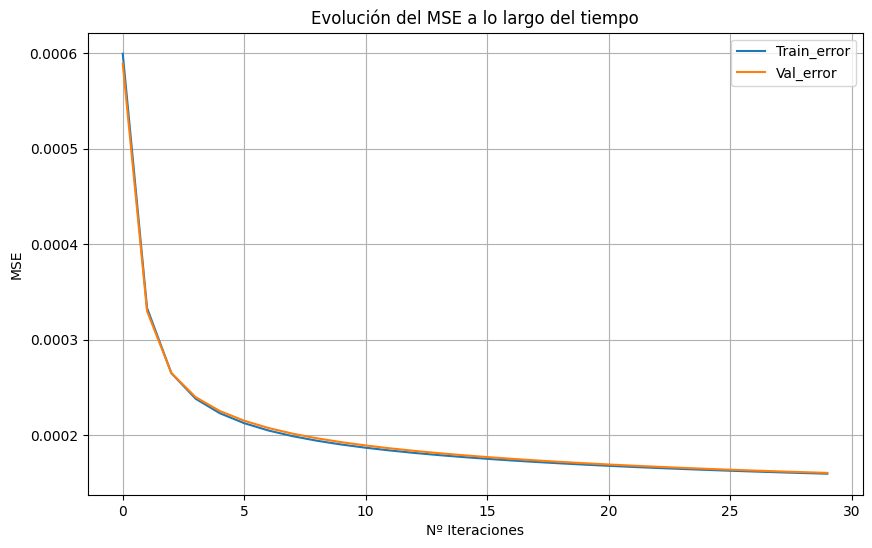

In [229]:
plt.figure(figsize=(10, 6))  # Tamaño de la gráfica

Epochs=[]
for elem in range(0,Adaline.n_iterations):
  Epochs.append(elem)

# Agregar datos de train_error y val_error a la gráfica
plt.plot(Epochs, Adaline.train_error_list, label='Train_error')
plt.plot(Epochs, Adaline.val_error_list, label='Val_error')

# Agregar etiquetas a los ejes
plt.xlabel('Nº Iteraciones')
plt.ylabel('MSE')

# Agregar una leyenda
plt.legend()

# Agregar un título
plt.title('Evolución del MSE a lo largo del tiempo')

# Mostrar la gráfica
plt.grid(True)
plt.show()

## Prediccion sobre el conjunto de test

Independientemente de si se han cargado los datos del mejor modelo, o se ha entrenado el Adaline desde 0, se debe realizar una prediccion sobre el conjunto de test, calcular el error, y posteriormente, guardar en fichero las salidas de la red para cada instancia de test (desnormalizado)

In [230]:
# Primero, realizamos la predicción sobre el conjunto de test:
y_pred = Adaline.predict(X_test)

# Calculamos el error del conjunto de test usando la funcion de nuestro Adaline
Error_pred = Adaline.calculate_error(X_test,y_test)
print(f'Error de test: {Error_pred:.6f}')

Error de test: 0.000156


## Guardar en fichero la salida de test para cada instancia

Una vez se ha calculado la prediccion de test para el mejor modelo, debemos guardar para cada instancia de test el resultado de la prediccion y nuestro target desnormalizados y en orden de menor a menor ( en base al valor de y_test)

In [231]:
# Una vez tenemos las predicciones, debemos desnormalizar los datos y añadirlos a un dataset:
resultados_test = pd.DataFrame(columns=["Target","Prediccion"])

i = 0
while i < 5510:
  var1 = y_pred[i]
  var2 = y_test[i]
  desnormalized_data_pred = (var1 * (max_TEY - min_TEY)) + min_TEY
  desnormalized_data_test = (var2 * (max_TEY - min_TEY)) + min_TEY
  resultados_test.loc[i] = [desnormalized_data_test,desnormalized_data_pred]
  i = i + 1

# Una vez tenemos los datos desnormalizados y en un DataFrame, podemos ordenarlos de mayor a menor dependiendo del valor de Target (y_test):

df = resultados_test.sort_values(by='Target')

# Una vez se tiene esto hecho, se puede guardar como un fichero:
df.to_csv('resultados_test_Adaline.csv', index=False)

# Imprimimos los 10 primeros:
print(df.iloc[:10,:])

      Target  Prediccion
4656  100.03   97.401899
3902  100.36   99.668534
1687  100.51   99.222042
368   100.52   99.295507
3923  100.58  101.292465
1874  100.66   99.696940
567   100.67   99.639134
241   100.72  100.536698
5400  100.74  100.580420
4701  100.74  101.201277


## Grafo y_test e y_pred para el mejor modelo

Las lineas naranjas son las predicciones, mientras que la linea azul son el Target

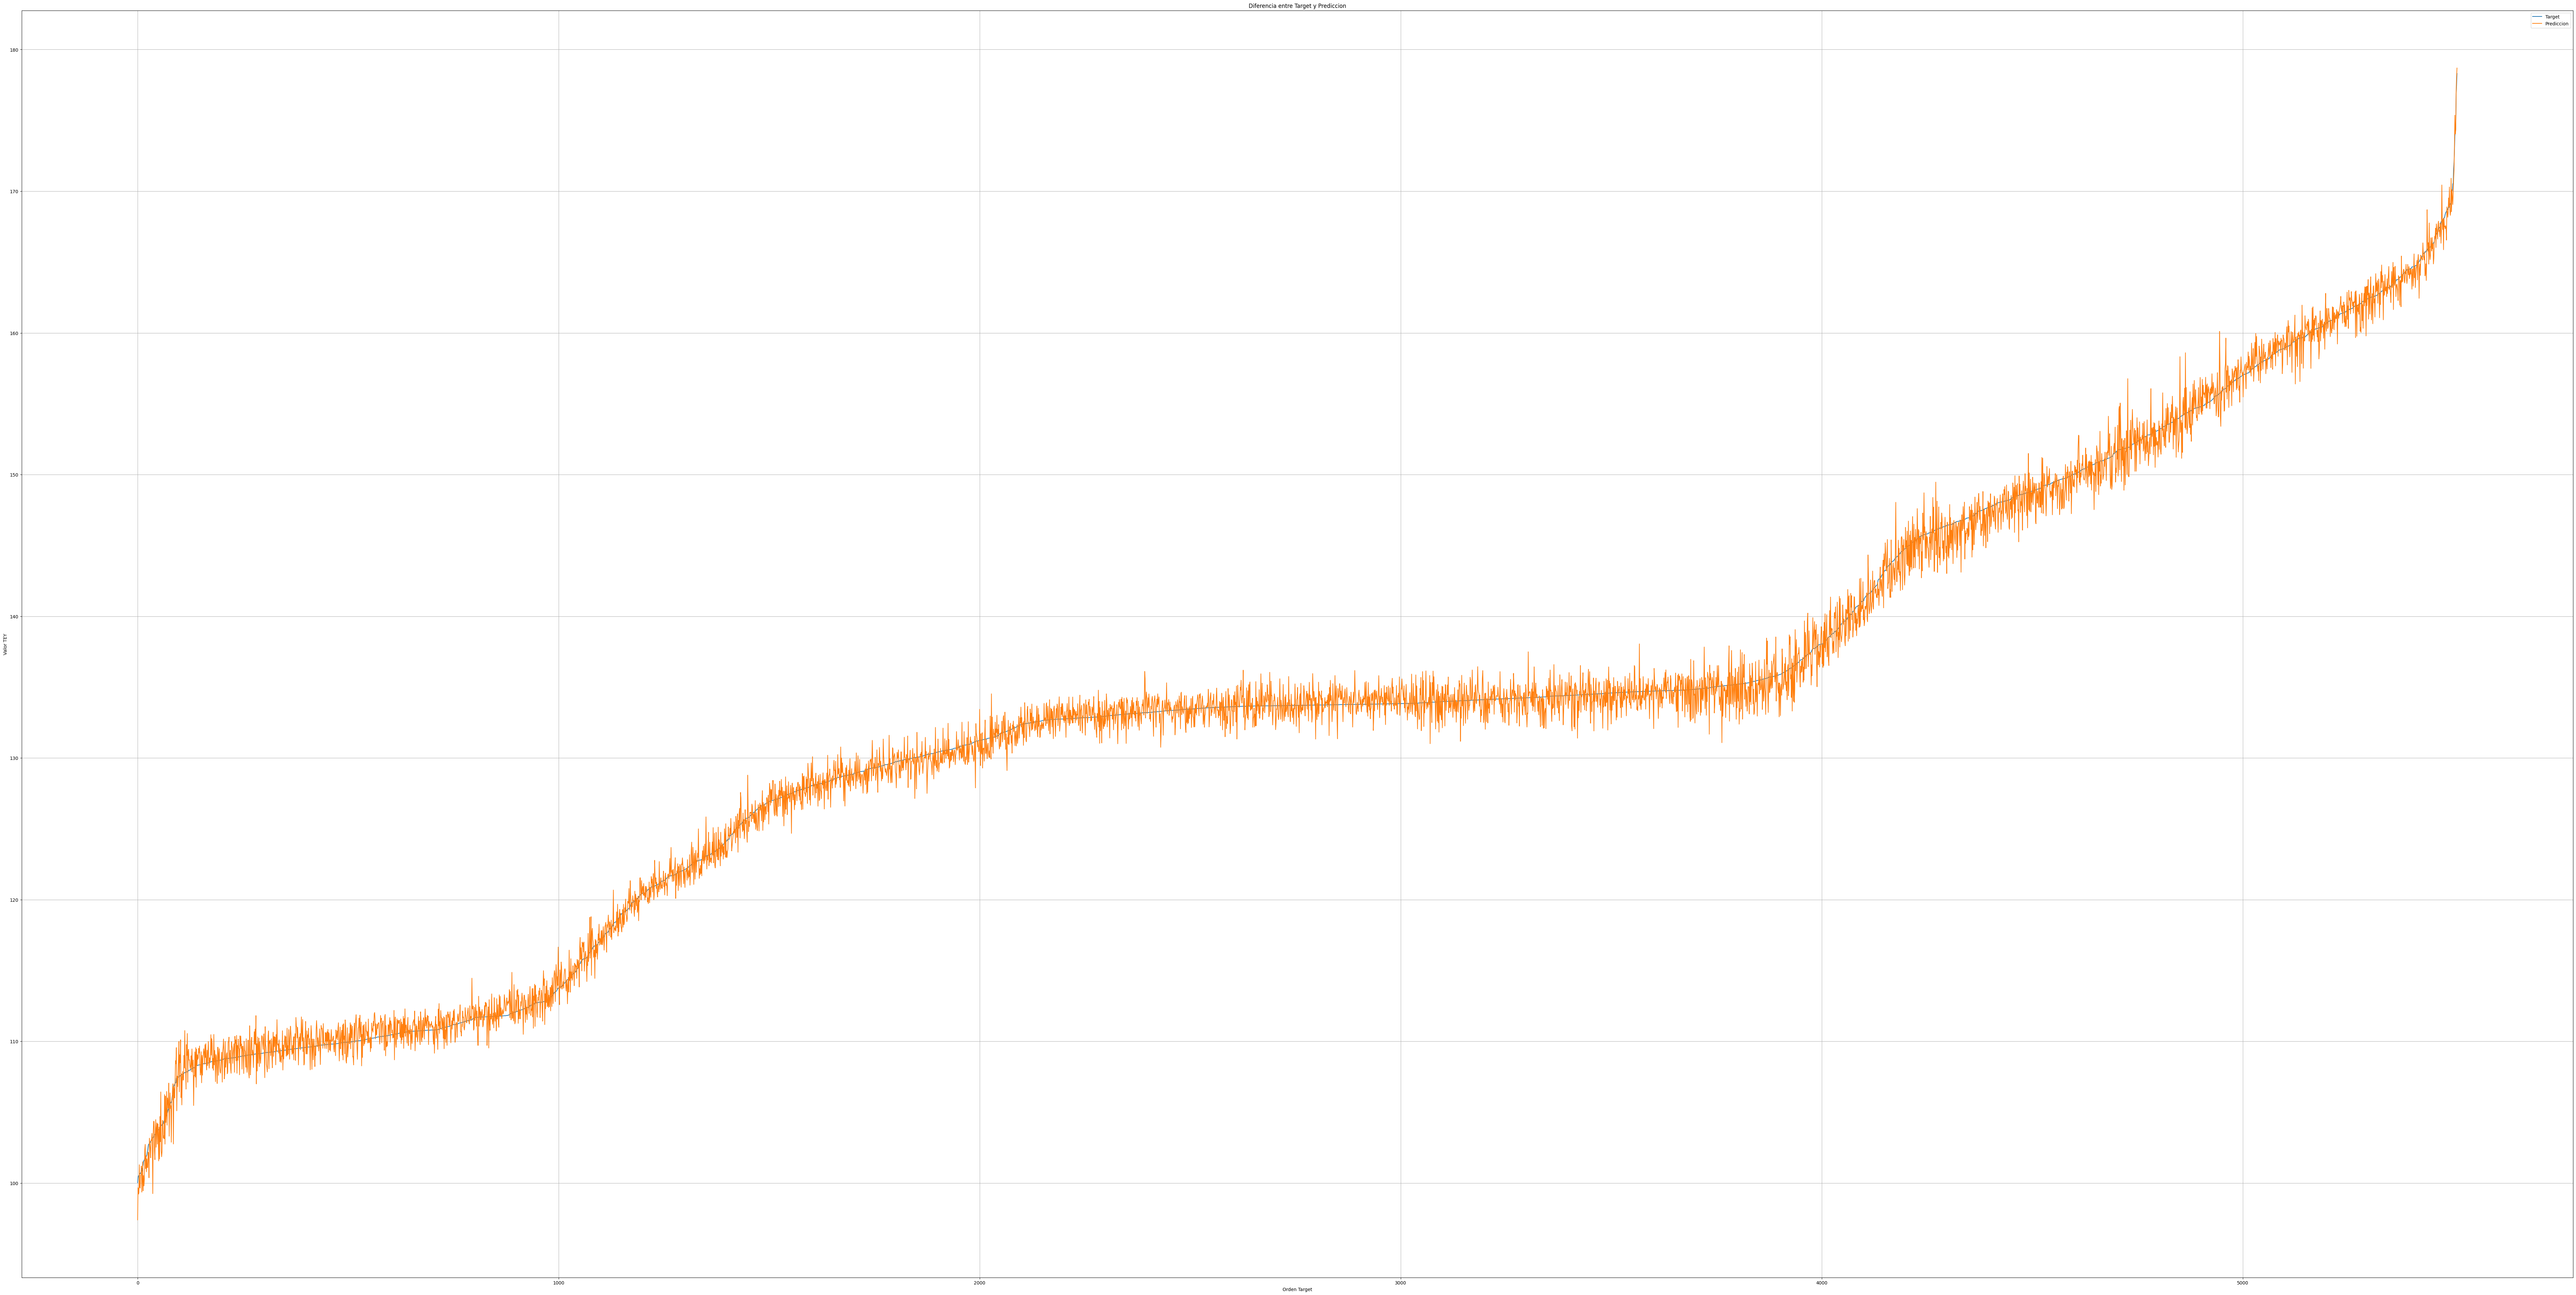

In [124]:
plt.figure(figsize=(100, 50))  # Tamaño de la gráfica

# Se recojen los resultados de test:
resultados_test_grafo = pd.read_csv("./resultados_test_Adaline.csv")

target = resultados_test_grafo["Target"]
pred = resultados_test_grafo["Prediccion"]

Epochs=[]
for elem in range(0,5510):
  Epochs.append(elem)

# Agregar datos de train_error y val_error a la gráfica
plt.plot(Epochs, target, label='Target')
plt.plot(Epochs, pred, label='Prediccion')

# Agregar etiquetas a los ejes
plt.xlabel('Orden Target')
plt.ylabel('Valor TEY')

# Agregar una leyenda
plt.legend()

# Agregar un título
plt.title('Diferencia entre Target y Prediccion')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# PARTE-2: Perceptron multicapa

Esta es la segunda parte de la práctica

## Imports

In [173]:
""" Regression problem: MLP con Keras """
import tensorflow as tf
import numpy as np
import pandas as pd
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense

## Cargar los datos
Una vez realizados los imports, debemos cargar los datos que vamos a utilizar para el PM, estos datos van a ser los mismos que los usados en el Adaline

In [187]:
entrenamiento=pd.read_csv("./entrenamiento.csv")
df = entrenamiento.drop(columns=["TEY"])
target = entrenamiento["TEY"]
ds = df.T

#Entrenamiento
X_train = entrenamiento.drop(columns=["TEY"])
y_train = entrenamiento["TEY"]
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()


test=pd.read_csv("./test.csv")

#Entrenamiento
X_test = test.drop(columns=["TEY"])
y_test = test["TEY"]
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()


validacion = pd.read_csv("./validacion.csv")

#Validacion
X_validacion = validacion.drop(columns=["TEY"])
y_validacion = validacion["TEY"]
X_validacion = X_validacion.to_numpy()
y_validacion = y_validacion.to_numpy()

## Ejemplos de modelos:
* PM con relu
* PM con Sigmoide
* Adaline (una sola neurona lineal) usando keras

In [188]:
# Definir forma de la entrada de la red
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla , en este caso sera (21,)

In [189]:
def create_PM_sigmoid(num_hidden_neurons = 50):#se pone un valor por defecto a num_hidden_neurons, pero puede llamarse con otro valor
  #1 capa oculta y 1 neurona de salida con sigmoide
  model = Sequential() # generamos el modelo dandole una forma secuencial:
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='sigmoid')) # capa con x=num_hidden_neurons neuronas activadas con sigmoide
  model.add(Dense(1,activation='sigmoid')) # capa con x=1 neurona (solo una neurona de salida) activada con sigmoide
  return model
def create_PM_relu(num_hidden_neurons = 50):
#1 capa oculta con relu y 1 neurona de salida con sigmoide
  model = Sequential()
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  return model
#modelo lineal, solo para comparar con el programa desarrollado.
def create_lineal(): # Una sola neurona lineal (Adaline)
  model = Sequential()
  model.add(Dense(1, input_shape=input_shape, activation='linear'))
  return model

## Definir el modelo de red de neuronas. Utilizando las funciones antes definidas

In [204]:
#Seleccionar el modelo llamando a la función correspondiente
model=create_PM_relu(100) # 1 capa relu con 100 neuronas y salida sigmoid
#model=create_PM_sigmoid(250) # 1 capa sigmoid con 20 neuronas y salida sigmoid
#model=create_lineal() # 1 capa salida LINEAL (ADALINE)
model.summary() #visualizar la estructura del modelo

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 100)               1100      
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1201 (4.69 KB)
Trainable params: 1201 (4.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compilar el modelo y entrenarlo

In [205]:
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.2 # razon de aprendizaje
epochs = 300 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32 # ¡¡¡¡¡¡ no cambiar este valor !!!!!!!!!!!!!!
# Para poder ver la curva de validación hay que poner validation_freq=1. Tarda más
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validacion,y_validacion),
shuffle=False, validation_freq=1)

Epoch 1/300
804/804 [==============================] - 3s 3ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/300
804/804 [==============================] - 2s 2ms/step - loss: 8.9443e-04 - mse: 8.9443e-04 - val_loss: 5.7648e-04 - val_mse: 5.7648e-04
Epoch 3/300
804/804 [==============================] - 3s 3ms/step - loss: 4.9010e-04 - mse: 4.9010e-04 - val_loss: 3.9817e-04 - val_mse: 3.9817e-04
Epoch 4/300
804/804 [==============================] - 2s 2ms/step - loss: 3.6841e-04 - mse: 3.6841e-04 - val_loss: 3.2325e-04 - val_mse: 3.2325e-04
Epoch 5/300
804/804 [==============================] - 2s 2ms/step - loss: 3.2093e-04 - mse: 3.2093e-04 - val_loss: 2.9345e-04 - val_mse: 2.9345e-04
Epoch 6/300
804/804 [==============================] - 2s 2ms/step - loss: 2.9783e-04 - mse: 2.9783e-04 - val_loss: 2.7613e-04 - val_mse: 2.7613e-04
Epoch 7/300
804/804 [==============================] - 2s 2ms/step - loss: 2.8280e-04 - mse: 2.8280e-04 - val_loss: 2.6393

## Plots de evolución del error

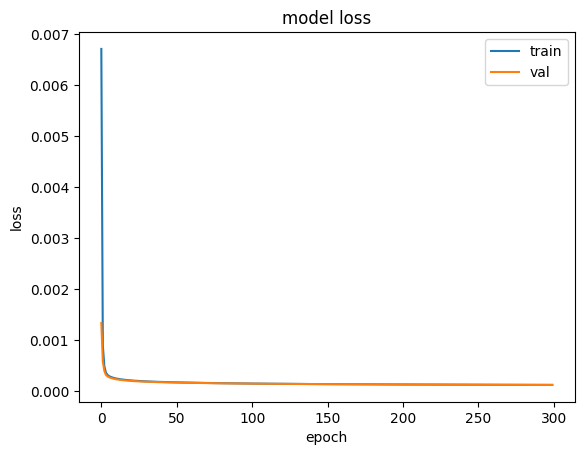

In [206]:
from matplotlib import pyplot as plt
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluar el modelo con el conjunto de test

In [211]:
#Evaluar el modelo con el fich de test
results_test = model.evaluate(X_test, y_test)
results_test[0]
#resultado es una lista con los valores de loss y las métricas elegidas.
#En este caso son loss y mse que coinciden.

173/173 [==============================] - 0s 2ms/step - loss: 1.2315e-04 - mse: 1.2315e-04


0.00012314837658777833

## Obtener la predicción para el conjunto de test.

In [218]:
# predicciones en test
test_pred = model.predict(X_test)

# Una vez tenemos las predicciones, debemos desnormalizar los datos y añadirlos a un dataset:
resultados_test = pd.DataFrame(columns=["Target","Prediccion"])

i = 0
while i < 5510:
  var1 = test_pred[i]
  var2 = y_test[i]
  var1 = var1[0]
  desnormalized_data_pred = (var1 * (max_TEY - min_TEY)) + min_TEY
  desnormalized_data_test = (var2 * (max_TEY - min_TEY)) + min_TEY
  resultados_test.loc[i] = [desnormalized_data_test,desnormalized_data_pred]
  i = i + 1

# Una vez tenemos los datos desnormalizados y en un DataFrame, podemos ordenarlos de mayor a menor dependiendo del valor de Target (y_test):

df = resultados_test.sort_values(by='Target')

# Una vez se tiene esto hecho, se puede guardar como un fichero:
df.to_csv('resultados_test_PM.csv', index=False)

# Imprimimos los 10 primeros:
print(df.iloc[:10,:])

173/173 [==============================] - 1s 3ms/step
      Target  Prediccion
4656  100.03  102.982073
3902  100.36  103.422852
1687  100.51  103.295755
368   100.52  105.265068
3923  100.58  104.424529
1874  100.66  103.432716
567   100.67  103.467012
241   100.72  103.705297
5400  100.74  103.783505
4701  100.74  104.141037


## Grafo de la predicción y target con el mejor modelo

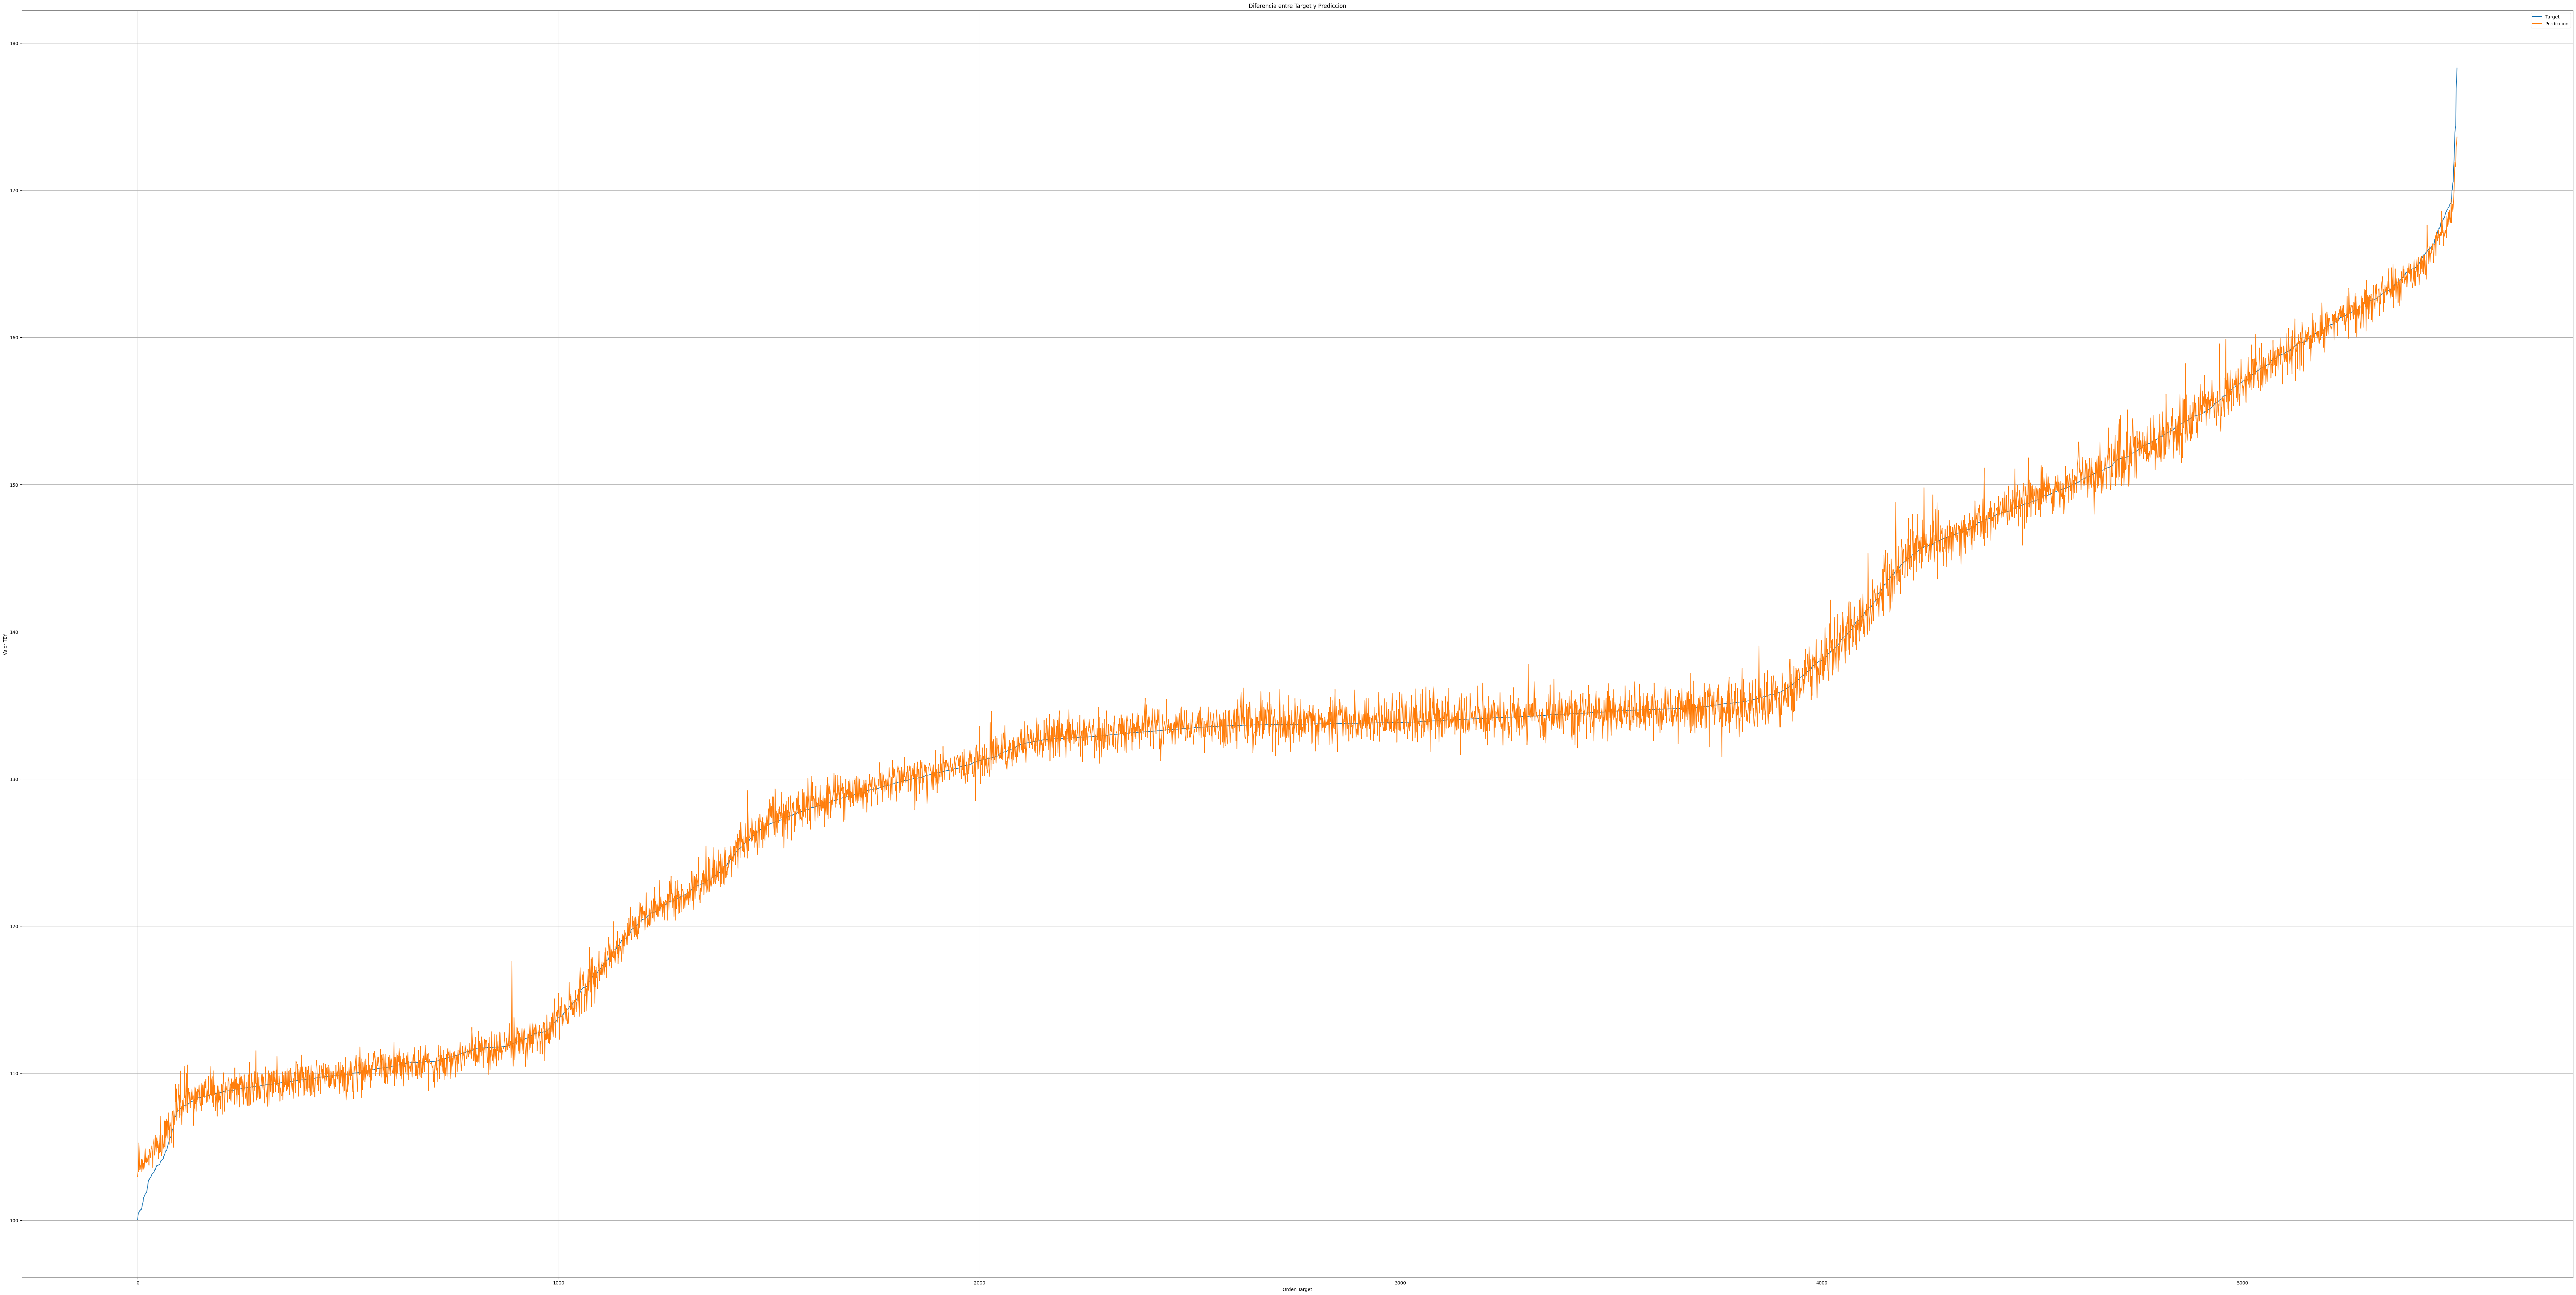

In [219]:
plt.figure(figsize=(100, 50))  # Tamaño de la gráfica

# Se recojen los resultados de test:
resultados_test_grafo = pd.read_csv("./resultados_test_PM.csv")

target = resultados_test_grafo["Target"]
pred = resultados_test_grafo["Prediccion"]

Epochs=[]
for elem in range(0,5510):
  Epochs.append(elem)

# Agregar datos de train_error y val_error a la gráfica
plt.plot(Epochs, target, label='Target')
plt.plot(Epochs, pred, label='Prediccion')

# Agregar etiquetas a los ejes
plt.xlabel('Orden Target')
plt.ylabel('Valor TEY')

# Agregar una leyenda
plt.legend()

# Agregar un título
plt.title('Diferencia entre Target y Prediccion')

# Mostrar la gráfica
plt.grid(True)
plt.show()

## Guardar los resultados de entrenamiento en ficheros

In [212]:
# GUARDAR RESULTADOS EN FICHEROS
# evolución del entrenamiento
# son los datos que se usan para construir los plots
# En este caso, la variable 'historico' contiene los datos del último entrenamiento realizado
np.savetxt('historicoTrainLoss.txt',historico.history['loss'])
np.savetxt('historicoValLoss.txt',historico.history['val_loss'])

# Guardar los resultados finales en ficheros

In [213]:
#guarda el modelo completo
model.save('modelo.h5')
#guarda solo pesos
model.save_weights('pesos.h5')
#cargar el modelo guardado
#from keras.models import load_model
#new_model = load_model('modelo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
